In [1]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random

from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

Note about the data: The dataset is rather large, and very skewed toward valid transactions. To balance it a bit better, we sample and only keep around 5% of the valid transactions

In [2]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]
    
csv_data = [row for row in csv_data if int(row[-1]) == 1 or random.random() < .05]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 14707 samples in total but only 492 cases of fraud


### Feature Scaling

In [3]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[-1.51964732e-01  1.30769057e-01 -2.30923082e-01  1.57674957e-01
 -1.18913753e-01 -2.67222800e-02 -1.90775467e-01  8.45269898e-04
 -7.18503485e-02 -1.80004531e-01  1.12468481e-01 -1.89663285e-01
  2.18321666e-04 -2.24024858e-01  2.93368820e-03 -1.27521387e-01
 -2.16925765e-01 -5.23044899e-02  8.74492530e-03  1.66200257e-02
  1.88457356e-02 -1.82161662e-03 -3.16102371e-04  4.16515276e-03
  1.42745966e-03 -3.64431523e-04  7.66959165e-04  3.00762063e-03
  9.07612273e+01]
[5.90912814e+00 3.54005589e+00 5.42436299e+00 2.89187780e+00
 3.12681746e+00 1.93758806e+00 4.15781267e+00 3.22098926e+00
 1.59632917e+00 2.91918284e+00 1.67817027e+00 2.85622153e+00
 1.00068235e+00 2.95684257e+00 8.54269703e-01 1.74619202e+00
 3.59400286e+00 1.10180523e+00 7.33150846e-01 5.41713252e-01
 1.12657841e+00 5.97500273e-01 5.49976655e-01 3.63082203e-01
 2.86717398e-01 2.39388643e-01 2.01536565e-01 8.33635972e-02
 5.70576462e+04]
The PCA features have mean 0 but different variances
The transaction amount is not 

In [4]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[ 1.17227533e-16 -6.48076743e-17  2.97971872e-16  1.86617416e-16
  1.32510368e-16 -1.06553328e-16 -2.80065780e-17 -3.53894441e-17
 -1.56708505e-16 -5.45749644e-17 -2.05255756e-16 -2.45333094e-16
 -4.93512139e-17  1.02624104e-16  4.29534848e-17 -2.42483368e-16
  6.29042084e-16 -4.63623987e-16  7.37154269e-17 -7.95771810e-17
  2.57937941e-17  4.18211434e-17 -6.66571653e-17 -6.69138294e-17
  1.49635145e-16 -3.53818951e-17 -2.31752545e-17  1.36786844e-17
  8.42584692e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


### Preliminary plotting

[ 1.11088034  1.38639697  0.92154368  1.11104797  1.19557162  1.24574381
 -0.82086022 -0.18292816 -0.61458611]


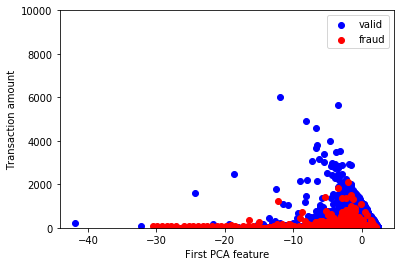

In [5]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

### Setting up cross-validation

In [6]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [7]:
def train_binary_SVM(data, scale=False, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        svm.fit(train_data, np.delete(labels, folds[i]))
        pred = svm.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    fscore = 2*confusion_mat[1,1] / (2*confusion_mat[1,1] + confusion_mat[0,1] + confusion_mat[1,0])
    print('F-score: {}'.format(fscore))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [8]:
train_binary_SVM(data);

Fold 0
[[2830   13]
 [  23   76]]
Fold 1
[[2840    3]
 [  25   74]]
Fold 2
[[2827   16]
 [  19   79]]
Fold 3
[[2833   10]
 [  17   81]]
Fold 4
[[2838    5]
 [  17   81]]
Final Confusion Matrix
[[2833.6    9.4]
 [  20.2   78.2]]
False negatives (valid): 0.0033063665142455153
False positives (fraud): 0.20528455284552843
F-score: 0.8408602150537635


#### Linear SVM with Scaling

In [9]:
train_binary_SVM(data, scale=True);

Fold 0
[[2841    2]
 [  21   78]]
Fold 1
[[2842    1]
 [  23   76]]
Fold 2
[[2836    7]
 [  16   82]]
Fold 3
[[2839    4]
 [  18   80]]
Fold 4
[[2842    1]
 [  16   82]]
Final Confusion Matrix
[[2840.     3. ]
 [  18.8   79.6]]
False negatives (valid): 0.001055223355610271
False positives (fraud): 0.1910569105691057
F-score: 0.8795580110497236


#### Linear SVM with Scaling and Class Weights

In [10]:
train_binary_SVM(data, scale=True, class_weight='balanced');

Fold 0
[[2753   90]
 [   8   91]]
Fold 1
[[2789   54]
 [   6   93]]
Fold 2
[[2733  110]
 [   9   89]]
Fold 3
[[2739  104]
 [   9   89]]
Fold 4
[[2765   78]
 [  10   88]]
Final Confusion Matrix
[[2755.8   87.2]
 [   8.4   90. ]]
False negatives (valid): 0.030671825536405208
False positives (fraud): 0.08536585365853658
F-score: 0.6531204644412192


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [11]:
train_binary_SVM(data, scale=True, kernel='rbf');

Fold 0
[[2842    1]
 [  19   80]]
Fold 1
[[2842    1]
 [  26   73]]
Fold 2
[[2842    1]
 [  18   80]]
Fold 3
[[2843    0]
 [  22   76]]
Fold 4
[[2842    1]
 [  19   79]]
Final Confusion Matrix
[[2.8422e+03 8.0000e-01]
 [2.0800e+01 7.7600e+01]]
False negatives (valid): 0.00028139289482940555
False positives (fraud): 0.21138211382113822
F-score: 0.8778280542986424


In [12]:
train_binary_SVM(data, kernel='rbf', class_weight='balanced');

Fold 0
[[2833   10]
 [  42   57]]
Fold 1
[[2835    8]
 [  49   50]]
Fold 2
[[2831   12]
 [  47   51]]
Fold 3
[[2820   23]
 [  49   49]]
Fold 4
[[2835    8]
 [  47   51]]
Final Confusion Matrix
[[2830.8   12.2]
 [  46.8   51.6]]
False negatives (valid): 0.0042912416461484346
False positives (fraud): 0.4756097560975609
F-score: 0.6362515413070284


#### Polynomial Kernel with Scaling and Class Weights

In [13]:
train_binary_SVM(data, scale=True, kernel='poly');

Fold 0
[[2842    1]
 [  19   80]]
Fold 1
[[2840    3]
 [  19   80]]
Fold 2
[[2837    6]
 [  14   84]]
Fold 3
[[2839    4]
 [  16   82]]
Fold 4
[[2842    1]
 [  17   81]]
Final Confusion Matrix
[[2840.     3. ]
 [  17.    81.4]]
False negatives (valid): 0.001055223355610271
False positives (fraud): 0.17276422764227642
F-score: 0.8905908096280087


In [14]:
train_binary_SVM(data, scale=True, kernel='poly', class_weight='balanced');

Fold 0
[[2828   15]
 [  15   84]]
Fold 1
[[2819   24]
 [  14   85]]
Fold 2
[[2817   26]
 [  12   86]]
Fold 3
[[2817   26]
 [  13   85]]
Fold 4
[[2823   20]
 [  14   84]]
Final Confusion Matrix
[[2820.8   22.2]
 [  13.6   84.8]]
False negatives (valid): 0.007808652831516004
False positives (fraud): 0.13821138211382114
F-score: 0.8257059396299903


### Logistic Regression

In [15]:
def train_logistic_regression(data, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    confusion_mat = np.zeros((2, 2))
    AU = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        pred1 = model.predict_proba(data[folds[i]])[:,1]
        #err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        #pred_valid = model.predict(data[valid_splits[i]])
        #err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        #pred_fraud = model.predict(data[fraud_splits[i]])
        #err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        #print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        #err += err_fold
        #err_valid += err_valid_fold
        #err_fraud += err_fraud_fold
        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred1)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        print('Fold', i)
        print(conf_mat)
        print('Area under curve:', area_under_curve)

        confusion_mat += conf_mat
    AU/=5
    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    return confusion_mat, AU
    #err /= 5
    #err_valid /= 5
    #err_fraud /= 5
    #print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    #return err, err_valid, err_fraud

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [16]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fscore = []
recall = []
precision = []
AU = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    cf,au = train_logistic_regression(data_sc, cw, C)
    TP = cf[1][1]
    FP = cf[0][1]
    FN = cf[1][0]
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    f1 = prec*rec*2/(prec+rec)
    print('F1 score:', f1)
    print('Recall:', rec)
    print('Precision:', prec)
    print('AUC:', au)
    fscore.append(f1)
    recall.append(rec)
    precision.append(prec)
    AU.append(au)

idx = np.argmax(AU)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under AUC metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(f1)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under F1 metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(precision)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under precision metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(recall)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under recall metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01
Fold 0
[[2842    1]
 [  19   80]]
Area under curve: 0.9798086386197536
Fold 1
[[2842    1]
 [  21   78]]
Area under curve: 0.9892488017707857
Fold 2
[[2842    1]
 [  18   80]]
Area under curve: 0.9808157522593983
Fold 3
[[2843    0]
 [  17   81]]
Area under curve: 0.9813325963519421
Fold 4
[[2842    1]
 [  16   82]]
Area under curve: 0.9765805020566087
Final Confusion Matrix
[[2.8422e+03 8.0000e-01]
 [1.8200e+01 8.0200e+01]]
F1 score: 0.8940914158305463
Recall: 0.8150406504065041
Precision: 0.9901234567901235
AUC: 0.9815572582116978
Checking class weight None and coefficient 0.016681005372000592


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

Fold 0
[[2842    1]
 [  18   81]]
Area under curve: 0.9803060503025328
Fold 1
[[2842    1]
 [  21   78]]
Area under curve: 0.9890640488600391
Fold 2
[[2842    1]
 [  16   82]]
Area under curve: 0.98172022942135
Fold 3
[[2843    0]
 [  17   81]]
Area under curve: 0.9814438613996427
Fold 4
[[2842    1]
 [  16   82]]
Area under curve: 0.9783140832836827
Final Confusion Matrix
[[2.8422e+03 8.0000e-01]
 [1.7600e+01 8.0800e+01]]
F1 score: 0.8977777777777778
Recall: 0.8211382113821137
Precision: 0.9901960784313726
AUC: 0.9821696546534495
Checking class weight None and coefficient 0.027825594022071243


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

Fold 0
[[2842    1]
 [  18   81]]
Area under curve: 0.9805227796786011
Fold 1
[[2842    1]
 [  20   79]]
Area under curve: 0.9885737430584424
Fold 2
[[2842    1]
 [  15   83]]
Area under curve: 0.9824165332682492
Fold 3
[[2843    0]
 [  17   81]]
Area under curve: 0.9814905209357752
Fold 4
[[2842    1]
 [  17   81]]
Area under curve: 0.9798789723416627
Final Confusion Matrix
[[2.8422e+03 8.0000e-01]
 [1.7400e+01 8.1000e+01]]
F1 score: 0.8990011098779134
Recall: 0.823170731707317
Precision: 0.9902200488997556
AUC: 0.982576509856546
Checking class weight None and coefficient 0.046415888336127774


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

Fold 0
[[2842    1]
 [  18   81]]
Area under curve: 0.9806791090646174
Fold 1
[[2842    1]
 [  20   79]]
Area under curve: 0.9879448725737856
Fold 2
[[2841    2]
 [  15   83]]
Area under curve: 0.9829190205804447
Fold 3
[[2843    0]
 [  17   81]]
Area under curve: 0.9815192344964718
Fold 4
[[2842    1]
 [  17   81]]
Area under curve: 0.9808121630643111
Final Confusion Matrix
[[2.842e+03 1.000e+00]
 [1.740e+01 8.100e+01]]
F1 score: 0.8980044345898003
Recall: 0.823170731707317
Precision: 0.9878048780487805
AUC: 0.9827748799559262
Checking class weight None and coefficient 0.0774263682681127


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

Fold 0
[[2842    1]
 [  18   81]]
Area under curve: 0.9803628973519933
Fold 1
[[2842    1]
 [  20   79]]
Area under curve: 0.9873692961979983
Fold 2
[[2840    3]
 [  15   83]]
Area under curve: 0.9831666750414553
Fold 3
[[2843    0]
 [  17   81]]
Area under curve: 0.981393612668423


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2842    1]
 [  17   81]]
Area under curve: 0.980740379162569
Final Confusion Matrix
[[2.8418e+03 1.2000e+00]
 [1.7400e+01 8.1000e+01]]
F1 score: 0.8970099667774087
Recall: 0.823170731707317
Precision: 0.9854014598540146
AUC: 0.9826065720844877
Checking class weight None and coefficient 0.1291549665014884
Fold 0
[[2842    1]
 [  18   81]]
Area under curve: 0.9799187797780833
Fold 1
[[2842    1]
 [  20   79]]
Area under curve: 0.9867404257133416
Fold 2
[[2840    3]
 [  15   83]]
Area under curve: 0.9836440379880408


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3
[[2842    1]
 [  16   82]]
Area under curve: 0.981095709476193
Fold 4
[[2842    1]
 [  17   81]]
Area under curve: 0.9804640111408616
Final Confusion Matrix
[[2.8416e+03 1.4000e+00]
 [1.7200e+01 8.1200e+01]]
F1 score: 0.8972375690607735
Recall: 0.8252032520325203
Precision: 0.983050847457627
AUC: 0.9823725928193042
Checking class weight None and coefficient 0.21544346900318834
Fold 0
[[2842    1]
 [  18   81]]
Area under curve: 0.9793645210458435
Fold 1
[[2842    1]
 [  20   79]]
Area under curve: 0.9860404964168594


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2
[[2840    3]
 [  15   83]]
Area under curve: 0.9839814223262291
Fold 3
[[2842    1]
 [  15   83]]
Area under curve: 0.9805788653836489
Fold 4
[[2842    1]
 [  18   80]]
Area under curve: 0.9798897399269241
Final Confusion Matrix
[[2.8416e+03 1.4000e+00]
 [1.7200e+01 8.1200e+01]]
F1 score: 0.8972375690607735
Recall: 0.8252032520325203
Precision: 0.983050847457627
AUC: 0.981971009019901
Checking class weight None and coefficient 0.3593813663804626
Fold 0
[[2842    1]
 [  18   81]]
Area under curve: 0.9790340975708546


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2842    1]
 [  20   79]]
Area under curve: 0.9853334612391945
Fold 2
[[2840    3]
 [  14   84]]
Area under curve: 0.9842972714938948
Fold 3
[[2841    2]
 [  15   83]]
Area under curve: 0.9801086808272376
Fold 4
[[2842    1]
 [  18   80]]
Area under curve: 0.9793693066392931
Final Confusion Matrix
[[2.8414e+03 1.6000e+00]
 [1.7000e+01 8.1400e+01]]
F1 score: 0.8974641675854466
Recall: 0.8272357723577236
Precision: 0.9807228915662651
AUC: 0.9816285635540949
Checking class weight None and coefficient 0.5994842503189409


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0
[[2842    1]
 [  18   81]]
Area under curve: 0.9785544505910316
Fold 1
[[2842    1]
 [  20   79]]
Area under curve: 0.9847614378039985
Fold 2
[[2840    3]
 [  14   84]]
Area under curve: 0.9845700503205151


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3
[[2841    2]
 [  15   83]]
Area under curve: 0.9796636206364361
Fold 4
[[2842    1]
 [  18   80]]
Area under curve: 0.9788955328877945
Final Confusion Matrix
[[2.8414e+03 1.6000e+00]
 [1.7000e+01 8.1400e+01]]
F1 score: 0.8974641675854466
Recall: 0.8272357723577236
Precision: 0.9807228915662651
AUC: 0.9812890184479551
Checking class weight None and coefficient 1.0
Fold 0
[[2842    1]
 [  18   81]]
Area under curve: 0.9781174388983043


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2842    1]
 [  20   79]]
Area under curve: 0.9843564025765925
Fold 2
[[2840    3]
 [  14   84]]
Area under curve: 0.984760277660132
Fold 3
[[2841    2]
 [  15   83]]
Area under curve: 0.9793298254933348


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2842    1]
 [  19   79]]
Area under curve: 0.9783140832836829
Final Confusion Matrix
[[2.8414e+03 1.6000e+00]
 [1.7200e+01 8.1200e+01]]
F1 score: 0.8962472406181017
Recall: 0.8252032520325203
Precision: 0.9806763285024155
AUC: 0.9809756055824094
Checking class weight balanced and coefficient 0.01
Fold 0
[[2780   63]
 [  11   88]]
Area under curve: 0.9773286860870399
Fold 1
[[2797   46]
 [   7   92]]
Area under curve: 0.9850812024572138
Fold 2
[[2766   77]
 [   9   89]]
Area under curve: 0.9848105263913515


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3
[[2772   71]
 [  10   88]]
Area under curve: 0.9779515745798848
Fold 4
[[2793   50]
 [  12   86]]
Area under curve: 0.9804245299949033
Final Confusion Matrix
[[2781.6   61.4]
 [   9.8   88.6]]
F1 score: 0.7133655394524959
Recall: 0.9004065040650406
Precision: 0.5906666666666667
AUC: 0.9811193039020786
Checking class weight balanced and coefficient 0.016681005372000592
Fold 0
[[2779   64]
 [  11   88]]
Area under curve: 0.9770799802456503
Fold 1
[[2789   54]
 [   6   93]]
Area under curve: 0.9849817201206579


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2
[[2762   81]
 [   9   89]]
Area under curve: 0.9847136181239995
Fold 3
[[2773   70]
 [  10   88]]
Area under curve: 0.9777541688500938
Fold 4
[[2792   51]
 [  11   87]]
Area under curve: 0.9802271242651123
Final Confusion Matrix
[[2779.    64. ]
 [   9.4   89. ]]
F1 score: 0.7080350039777247
Recall: 0.9044715447154471
Precision: 0.5816993464052288
AUC: 0.9809513223211027
Checking class weight balanced and coefficient 0.027825594022071243
Fold 0
[[2778   65]
 [  10   89]]
Area under curve: 0.9766713920776531


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2788   55]
 [   6   93]]
Area under curve: 0.9848893436652846
Fold 2
[[2762   81]
 [   9   89]]
Area under curve: 0.9846167098566475
Fold 3
[[2772   71]
 [  10   88]]
Area under curve: 0.9774849792185605
Fold 4
[[2793   50]
 [  11   87]]
Area under curve: 0.9797497613185269
Final Confusion Matrix
[[2778.6   64.4]
 [   9.2   89.2]]
F1 score: 0.7079365079365079
Recall: 0.9065040650406504
Precision: 0.5807291666666666
AUC: 0.9806824372273345
Checking class weight balanced and coefficient 0.046415888336127774


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0
[[2774   69]
 [  10   89]]
Area under curve: 0.9764404509392198
Fold 1
[[2787   56]
 [   6   93]]
Area under curve: 0.9847792025069548
Fold 2
[[2759   84]
 [   9   89]]
Area under curve: 0.9845054448089472
Fold 3
[[2773   70]
 [  10   88]]
Area under curve: 0.9771798976361561


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2788   55]
 [  11   87]]
Area under curve: 0.9793764850294673
Final Confusion Matrix
[[2776.2   66.8]
 [   9.2   89.2]]
F1 score: 0.7012578616352201
Recall: 0.9065040650406504
Precision: 0.5717948717948718
AUC: 0.9804562961841491
Checking class weight balanced and coefficient 0.0774263682681127
Fold 0
[[2773   70]
 [  10   89]]
Area under curve: 0.9762059568601954
Fold 1
[[2786   57]
 [   6   93]]
Area under curve: 0.9845482613685217


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2
[[2757   86]
 [   9   89]]
Area under curve: 0.9844372501022921
Fold 3
[[2772   71]
 [  10   88]]
Area under curve: 0.9770399190277588
Fold 4
[[2785   58]
 [  11   87]]
Area under curve: 0.9792077928603732
Final Confusion Matrix
[[2774.6   68.4]
 [   9.2   89.2]]
F1 score: 0.6968749999999999
Recall: 0.9065040650406504
Precision: 0.565989847715736
AUC: 0.9802878360438282
Checking class weight balanced and coefficient 0.1291549665014884


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0
[[2773   70]
 [  10   89]]
Area under curve: 0.9759963333653098
Fold 1
[[2787   56]
 [   6   93]]
Area under curve: 0.9841538849628896
Fold 2
[[2757   86]
 [   9   89]]
Area under curve: 0.9844049473465081


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3
[[2770   73]
 [  10   88]]
Area under curve: 0.9769322431751455
Fold 4
[[2785   58]
 [  11   87]]
Area under curve: 0.979103706202847
Final Confusion Matrix
[[2774.4   68.6]
 [   9.2   89.2]]
F1 score: 0.6963309914129586
Recall: 0.9065040650406504
Precision: 0.5652724968314322
AUC: 0.9801182230105401
Checking class weight balanced and coefficient 0.21544346900318834
Fold 0
[[2770   73]
 [   9   90]]
Area under curve: 0.9758826392663889


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2785   58]
 [   6   93]]
Area under curve: 0.9837666144384399
Fold 2
[[2758   85]
 [   9   89]]
Area under curve: 0.9844480176875535
Fold 3
[[2769   74]
 [  10   88]]
Area under curve: 0.9768353349077936


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2784   59]
 [  11   87]]
Area under curve: 0.9789709059846239
Final Confusion Matrix
[[2773.2   69.8]
 [   9.    89.4]]
F1 score: 0.6940993788819876
Recall: 0.9085365853658537
Precision: 0.5615577889447237
AUC: 0.9799807024569599
Checking class weight balanced and coefficient 0.3593813663804626
Fold 0
[[2770   73]
 [   9   90]]
Area under curve: 0.9759181686723016
Fold 1
[[2781   62]
 [   6   93]]
Area under curve: 0.9834894850723201


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2
[[2758   85]
 [   9   89]]
Area under curve: 0.9844516068826406
Fold 3
[[2770   73]
 [  10   88]]
Area under curve: 0.9768568700783163
Fold 4
[[2784   59]
 [  11   87]]
Area under curve: 0.978873997717272
Final Confusion Matrix
[[2772.6   70.4]
 [   9.    89.4]]
F1 score: 0.6924864446165764
Recall: 0.9085365853658537
Precision: 0.5594493116395495
AUC: 0.9799180256845702
Checking class weight balanced and coefficient 0.5994842503189409


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0
[[2768   75]
 [   9   90]]
Area under curve: 0.9759483686673276
Fold 1
[[2780   63]
 [   6   93]]
Area under curve: 0.9833793439139905
Fold 2
[[2757   86]
 [   9   89]]
Area under curve: 0.9844480176875533


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3
[[2769   74]
 [  10   88]]
Area under curve: 0.976946599955494
Fold 4
[[2785   58]
 [  11   87]]
Area under curve: 0.9789170680583172
Final Confusion Matrix
[[2771.8   71.2]
 [   9.    89.4]]
F1 score: 0.6903474903474903
Recall: 0.9085365853658537
Precision: 0.5566625155666252
AUC: 0.9799278796565364
Checking class weight balanced and coefficient 1.0
Fold 0
[[2769   74]
 [   9   90]]
Area under curve: 0.9760194274791532


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1
[[2781   62]
 [   6   93]]
Area under curve: 0.9832905203992084
Fold 2
[[2757   86]
 [   9   89]]
Area under curve: 0.9844767312482502
Fold 3
[[2771   72]
 [  10   88]]
Area under curve: 0.977011205467062


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4
[[2785   58]
 [  11   87]]
Area under curve: 0.9789601383993626
Final Confusion Matrix
[[2772.6   70.4]
 [   9.    89.4]]
F1 score: 0.6924864446165764
Recall: 0.9085365853658537
Precision: 0.5594493116395495
AUC: 0.9799516045986072
Best parameters found for Logistic Regression under AUC metric is None class weights and 0.046415888336127774 coefficient
Best parameters found for Logistic Regression under F1 metric is None class weights and 0.01 coefficient
Best parameters found for Logistic Regression under precision metric is None class weights and 0.027825594022071243 coefficient
Best parameters found for Logistic Regression under recall metric is balanced class weights and 0.21544346900318834 coefficient


# kNN

In [17]:
def train_KNN(data, k, scale=False):
    confusion_mat = np.zeros((2, 2))
    AU = 0
    errors = 0
    for i in range(5):
        knn = KNeighborsClassifier(n_neighbors=k)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        knn.fit(train_data, np.delete(labels, folds[i]))
        pred = knn.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
#         print('Fold', i)
#         print(conf_mat)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
#         print('Fold', i)
#         print(conf_mat)
#         print('Area under curve:', area_under_curve)
        err = sum([1 if a != b else 0 for a, b in zip(labels[folds[i]], pred)]) / len(pred)
        errors += err

        confusion_mat += conf_mat

    confusion_mat /= 5
    AU /= 5
    errors /= 5
#     print('Final Confusion Matrix')
#     print(confusion_mat)
    
#     fnr = confusion_mat[0, 1] / sum(confusion_mat[0, :])
#     fpr = confusion_mat[1, 0] / sum(confusion_mat[1,:])
#     print('False negatives (valid):', fnr)
#     print('False positives (fraud):', fpr)
    
#     metric = (fnr * (len(labels) - sum(labels)) + fpr * sum(labels)) / len(labels)
    return confusion_mat, AU, errors

In [18]:
for k in [1, 3, 5, 7, 9, 11]:
    conf, au, errors = train_KNN(data, k)
    print('K = {}, errors = {}'.format(k, errors))
    print('Confusion Matrix:')
    print(conf)
#     print('AUC: {}'.format(au))
#     print('recall: {}'.format(conf[1, 0] / sum(conf[:, 0])))
    fnr = conf[0, 1] / sum(conf[0, :])
    fpr = conf[1, 0] / sum(conf[1,:])
#     metric = (fnr * (len(labels) - sum(labels)) + fpr * sum(labels)) / len(labels)
#     print('metric: {}'.format(metric))
    fscore = 2*conf[1,1] / (2*conf[1,1] + conf[0,1] + conf[1,0])
    print('fscore: {}'.format(fscore))
    print()

K = 1, errors = 0.010879150369688397
Confusion Matrix:
[[2831.8   11.2]
 [  20.8   77.6]]
fscore: 0.829059829059829

K = 3, errors = 0.008907240076824733
Confusion Matrix:
[[2.8408e+03 2.2000e+00]
 [2.4000e+01 7.4400e+01]]
fscore: 0.8502857142857143

K = 5, errors = 0.00938322240870822
Confusion Matrix:
[[2.8416e+03 1.4000e+00]
 [2.6200e+01 7.2200e+01]]
fscore: 0.8395348837209302

K = 7, errors = 0.011151166690667654
Confusion Matrix:
[[2.8416e+03 1.4000e+00]
 [3.1400e+01 6.7000e+01]]
fscore: 0.803357314148681

K = 9, errors = 0.011627172137466248
Confusion Matrix:
[[2.8418e+03 1.2000e+00]
 [3.3000e+01 6.5400e+01]]
fscore: 0.7927272727272728

K = 11, errors = 0.012103062009689311
Confusion Matrix:
[[2.8418e+03 1.2000e+00]
 [3.4400e+01 6.4000e+01]]
fscore: 0.78239608801956

